### Tutorial for optimizing a linear policy for MountainCar Continuous

### Overview

Major Modules:

- World: In this case - MountaincarContinuousActionWorld, is the gym environment in which the agent interacts and receives a certain reward for performed actions following a policy. Here, max trajectory length is configurable and is currently set to 300 for an episode.

- Agent: This module consists of 3 sub modules namely EpisodeRewardBufferNoBias, LinearPolicy, and LLMBrain. The agent interacts in the world based on actions given by the linear policy. The policy is optimized by the llm brain by injecting agent rollout into the prompt and getting suggested updates to the policy weights. The replay buffer module handles storing weights and episode accumulated rewards to be added to the prompt.

Sub Modules:
 - LLMBrain: Handles interaction with LLM and generates prompt and optimizations based on LLM response for the agent.
 - LinearPolicy: Stores weights for the model, and generates actions for the agent.
 - EpisodeRewardBufferNoBias: Used to add (weight, accumulated reward) pair to the buffer when is then fed into the prompt by LLMBrain.

In [1]:
import re
import os
import time
from decimal import Decimal
from collections import deque
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import gymnasium as gym
from openai import OpenAI
from jinja2 import Template
import google.generativeai as genai

/opt/miniconda3/envs/lm-agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
NUM_EPISODES=400 # Total number of episodes to train for
RENDER_MODE=None # Choose from 'human', 'rgb_array', or None
MAX_TRAJ_COUNT=1000 # Maximum number of trajectories to store in buffer for prompt
MAX_TRAJ_LENGTH=1000 # Maximum number of steps in a trajectory
LLM_MODEL_NAME="gpt-4o" # LLM for optimization, choose from "o1-preview","gpt-4o","gemini-2.0-flash-exp","gpt-4o-mini","gemini-1.5-flash","gemini-1.5-flash-8b","o3-mini-2025-01-31"
NUM_EVALUATION_EPISODES=20 # Number of episodes to generate agent rollouts for evaluation
WARMUP_EPISODES=20 # Number of randomly generated initial episodes
SEARCH_STD=1.0 # Step size for LLM to search for optimal parameters during exploration

### Prompt Template

In [3]:
LLM_SI_TEMPLATE_STRING = """You are an optimization assistant, helping me find the global maximum of a mathematical function.  
I will give you the function evaluation and the current iteration number at each step. 
Your goal is to propose input values that efficiently lead us to the global maximum within a limited number of iterations (300). 

Here's how we'll interact:

1. I will first provide MAX_STEPS (300) along with a few training examples.
2. You will provide your response in the following exact format:
    * Line 1: a new input 'a: , b: ', aiming to maximize the function's value f(a,b). 
    * Line 2: a brief (one sentence) explanation of why you chose that input, considering the current iteration.
3. I will then provide the function's value f(a,b) at that point, and the current iteration.
4. We will repeat steps 2-3 until we reach the maximum number of iterations.

Remember:

* **Assume no prior knowledge about the function's specific form.**
* **Balance Exploitation and Exploration:**  Early on, explore broadly. As iterations increase, focus more on promising regions.
* **Be adaptable:**  Your approach might need to change based on the function's behavior and the remaining iterations. 
* **Do not propose previously seen input pairs.**
* **Explore with smaller step size around the historical best values.**
* **Each input variable has some interplay with each other**
* **Try to use step size of {{ search_std }} when you perform the explorations.**
If you think you are stuck in a local maxima or making small increments for too long, 
try more exploratory values and then eventually exploit new values based on your understanding of the function.


The expected optimum value should be over 50. Please do not be trapped in local optimums. Search between -7 and 7.


Next, you will see examples of a,b and f(a,b) pairs.
{{ episode_reward_buffer_string }}

Now you are at iteration {{step_number}}. Please provide the results in the indicated format. Do not provide any additional texts."""


llm_si_template = Template(LLM_SI_TEMPLATE_STRING)

### World

In [4]:
# MountainCarContinuous-v0
# https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/

class MountaincarContinuousActionWorld():
    def __init__(
        self,
        gym_env_name,
        render_mode,
        max_traj_length=300,
    ):
        assert render_mode in ["human", "rgb_array", None]
        self.name = gym_env_name
        self.env = gym.make(gym_env_name, render_mode=render_mode)
        self.steps = 0
        self.accu_reward = 0
        self.max_traj_length = max_traj_length

    def reset(self):
        state, _ = self.env.reset()
        self.steps = 0
        self.accu_reward = 0
        return state

    def step(self, action):
        self.steps += 1
        action = action[0]
        state, reward, done, _, _ = self.env.step(action)
        self.accu_reward += reward

        if self.steps >= self.max_traj_length:
            done = True

        return state, reward, done

    def get_accu_reward(self):
        return self.accu_reward

### Sub Modules

In [5]:
class EpisodeRewardBufferNoBias:
    """
    Buffer to store weights and accumulated rewards for each episode. Follows FIFO queue with a maximum size of "MAX_TRAJ_COUNT".
    """
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, weights: np.ndarray, reward):
        self.buffer.append((weights, reward))
    
    def __str__(self):
        buffer_table = "Parameters | Reward\n"
        for weights, reward in self.buffer:
            buffer_table += f"{weights.reshape(1, -1)} | {reward}\n"
        return buffer_table

    def load(self, folder):
        # Find all episode files
        all_files = [os.path.join(folder, x) for x in os.listdir(folder) if x.startswith('warmup_rollout')]
        all_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

        # Load parameters from all episodes
        for filename in all_files:
            with open(filename, 'r') as f:
                lines = f.readlines()
                parameters = []
                for line in lines:
                    if "parameter ends" in line:
                        break
                    try:
                        parameters.append([float(x) for x in line.split(',')])
                    except:
                        continue
                parameters = np.array(parameters)

                rewards = []
                for line in lines:
                    if "Total reward" in line:
                        try:
                            rewards.append(float(line.split()[-1]))
                        except:
                            continue
                rewards_mean = np.mean(rewards)
                self.add(parameters, rewards_mean)
                f.close()


class LinearPolicy():
    """
    Linear policy for continuous action space. The policy is represented as a (2,1) matrix of weights.
    Next action is calculated as the dot product of the state and the weight matrix.
    state.T * weight -> action
    (1,2) * (2,1) -> (1,1)
    """
    def __init__(self, dim_states, dim_actions):
        self.dim_states = dim_states
        self.dim_actions = dim_actions
        self.weight = np.random.rand(self.dim_states, self.dim_actions)

    def initialize_policy(self):
        self.weight = np.round((np.random.rand(self.dim_states, self.dim_actions) - 0.5) * 6, 1)

    def get_action(self, state):
        state = state.T
        return np.matmul(state, self.weight)

    def __str__(self):
        output = "Weights:\n"
        for w in self.weight:
            output += ", ".join([str(i) for i in w])
            output += "\n"

        return output

    def update_policy(self, weight_and_bias_list):
        if weight_and_bias_list is None:
            return
        self.weight = np.array(weight_and_bias_list, dtype=np.float64).reshape(-1)
        self.weight = np.array([float(Decimal(str(w)).normalize()) 
                           for w in self.weight], dtype=np.float64)
        self.weight = self.weight.reshape(
            self.dim_states, self.dim_actions
        )


class LLMBrain:
    """
    Interacts with LLM for optimization of policy parameters.
    """
    def __init__(
        self,
        llm_si_template: Template,
        llm_model_name: str,
    ):
        self.llm_si_template = llm_si_template
        self.llm_conversation = []
        assert llm_model_name in [
            "o1-preview",
            "gpt-4o",
            "gemini-2.0-flash-exp",
            "gpt-4o-mini",
            "gemini-1.5-flash",
            "gemini-1.5-flash-8b",
            "o3-mini-2025-01-31",
        ]
        self.llm_model_name = llm_model_name
        if "gemini" in llm_model_name:
            self.model_group = "gemini"
            genai.configure(api_key=os.environ["GEMINI_API_KEY"])
        else:
            self.model_group = "openai"
            self.client = OpenAI()

    def reset_llm_conversation(self):
        self.llm_conversation = []

    def add_llm_conversation(self, text, role):
        if self.model_group == "openai":
            self.llm_conversation.append({"role": role, "content": text})
        else:
            self.llm_conversation.append({"role": role, "parts": text})

    def query_llm(self):
        for attempt in range(5):
            try:
                if self.model_group == "openai":
                    completion = self.client.chat.completions.create(
                        model=self.llm_model_name,
                        messages=self.llm_conversation,
                    )
                    response = completion.choices[0].message.content
                else:
                    model = genai.GenerativeModel(model_name=self.llm_model_name)
                    chat_session = model.start_chat(history=self.llm_conversation[:-1])
                    response = chat_session.send_message(
                        self.llm_conversation[-1]["parts"]
                    )
                    response = response.text
            except Exception as e:
                print(f"Error: {e}")
                print("Retrying...")
                if attempt == 4:
                    raise Exception("Failed")
                else:
                    print("Waiting for 60 seconds before retrying...")
                    time.sleep(60)

            if self.model_group == "openai":
                # add the response to self.llm_conversation
                self.add_llm_conversation(response, "assistant")
            else:
                self.add_llm_conversation(response, "model")

            return response

    def parse_parameters(self, parameters_string):
        new_parameters_list = []

        # Update the Q-table based on the new Q-table
        for row in parameters_string.split("\n"):
            if row.strip().strip(","):
                try:
                    parameters_row = [
                        float(x.strip().strip(",")) for x in row.split(",")
                    ]
                    new_parameters_list.append(parameters_row)
                except Exception as e:
                    print(e)

        return new_parameters_list

    def llm_update_parameters_num_optim(
        self, episode_reward_buffer, parse_parameters, step_number, search_std
    ):
        self.reset_llm_conversation()

        system_prompt = self.llm_si_template.render(
            {
                "episode_reward_buffer_string": str(episode_reward_buffer),
                "step_number": str(step_number),
                "search_std": str(search_std),
            }
        )

        self.add_llm_conversation(system_prompt, "user")
        new_parameters_with_reasoning = self.query_llm()
        print(system_prompt)

        new_parameters_list = parse_parameters(new_parameters_with_reasoning)

        return (
            new_parameters_list,
            "system:\n"
            + system_prompt
            + "\n\n\nLLM:\n"
            + new_parameters_with_reasoning,
        )

### Agent

In [6]:
class MountaincarContinuousActionLLMNumOptimAgent:
    def __init__(
        self,
        logdir,
        dim_action,
        dim_state,
        max_traj_count,
        llm_si_template,
        llm_model_name,
        num_evaluation_episodes,
    ):
        self.policy = LinearPolicy(dim_actions=dim_action, dim_states=dim_state)
        self.replay_buffer = EpisodeRewardBufferNoBias(max_size=max_traj_count)
        self.llm_brain = LLMBrain(
            llm_si_template, llm_model_name
        )
        self.logdir = logdir
        self.num_evaluation_episodes = num_evaluation_episodes
        self.training_episodes = 0

    def rollout_episode(self, world: MountaincarContinuousActionWorld, logging_file, record=True):
        state = world.reset()
        state = np.expand_dims(state, axis=0)
        logging_file.write(f"state | action | reward\n")
        done = False
        step_idx = 0
        while not done:
            action = self.policy.get_action(state.T)
            action = np.reshape(action, (1, 1))
            next_state, reward, done = world.step(action)
            logging_file.write(f"{state.T[0]} | {action[0]} | {reward}\n")
            state = next_state
            step_idx += 1
        logging_file.write(f"Total reward: {world.get_accu_reward()}\n")
        if record:
            self.replay_buffer.add(
                self.policy.weight, world.get_accu_reward()
            )
        return world.get_accu_reward()

    def random_warmup(self, world: MountaincarContinuousActionWorld, logdir, num_episodes):
        for episode in range(num_episodes):
            self.policy.initialize_policy()
            # Run the episode and collect the trajectory
            print(f"Rolling out warmup episode {episode}...")
            logging_filename = f"{logdir}/warmup_rollout_{episode}.txt"
            logging_file = open(logging_filename, "w")
            result = self.rollout_episode(world, logging_file)
            print(f"Result: {result}")

    def train_policy(self, world: MountaincarContinuousActionWorld, logdir, search_std):

        def parse_parameters(input_text):
            # This regex looks for integers or floating-point numbers (including optional sign)
            s = input_text.split("\n")[0]
            pattern = r"[-+]?\d+(?:\.\d+)?"
            matches = re.findall(pattern, s)

            # Convert matched strings to float (or int if you prefer to differentiate)
            results = []
            for match in matches:
                results.append(float(match))
            assert len(results) == 2
            return np.array(results).reshape((2, 1))

        def str_2d_examples(replay_buffer: EpisodeRewardBufferNoBias):

            all_parameters = []
            for weights, reward in replay_buffer.buffer:
                parameters = weights
                all_parameters.append((parameters.reshape(-1), reward))

            text = ""
            for parameters, reward in all_parameters:
                l = ""
                for i in range(2):
                    l += f'{"abcdefghijklmnopqr"[i]}: {parameters[i]}; '
                fxy = reward
                l += f"f(a,b): {fxy}\n"
                text += l
            return text

        # Run the episode and collect the trajectory
        print(f"Rolling out episode {self.training_episodes}...")
        logging_filename = f"{logdir}/training_rollout.txt"
        logging_file = open(logging_filename, "w")
        result = self.rollout_episode(world, logging_file)
        print(f"Result: {result}")

        # Update the policy using llm_brain, q_table and replay_buffer
        print("Updating the policy...")
        new_parameter_list, reasoning = self.llm_brain.llm_update_parameters_num_optim(
            str_2d_examples(self.replay_buffer),
            parse_parameters,
            self.training_episodes,
            search_std,
        )

        self.policy.update_policy(new_parameter_list)
        logging_q_filename = f"{logdir}/parameters.txt"
        logging_q_file = open(logging_q_filename, "w")
        logging_q_file.write(str(self.policy))
        logging_q_file.close()
        q_reasoning_filename = f"{logdir}/parameters_reasoning.txt"
        q_reasoning_file = open(q_reasoning_filename, "w")
        q_reasoning_file.write(reasoning)
        q_reasoning_file.close()
        print("Policy updated!")

        self.training_episodes += 1

    def evaluate_policy(self, world: MountaincarContinuousActionWorld, logdir):
        results = []
        for idx in range(self.num_evaluation_episodes):
            logging_filename = f"{logdir}/evaluation_rollout_{idx}.txt"
            logging_file = open(logging_filename, "w")
            result = self.rollout_episode(world, logging_file, record=False)
            results.append(result)
        return results

### Training

Generates a log dir with following structure inside `logs/mountaincar_continuous_action_llm_num_optim_400_std_1_expected_r_no_bias_range/`:
 - episode_0
    * evaluation_rollout_0.txt
    * .
    * evaluation_rollout_n.txt - contains state, action, reward trajectory of the agent 
    * parameters_reasoning.txt - LLM reasoning text for episode 0
    * parameters.txt - consists of weights for the policy after episode 0
    * training_rollout.txt
 - episode_1
 - .
 - episode_n
 - warmup

##### Training loop:
 - Generate warmup episodes, add to replay buffer
 - Update the prompt with replay buffer
      - Request LLM for new parameters
      - Update agent's policy with new parameters
      - evaluate new policy and add to replay buffer
      - repeat
 - end

In [7]:
def run_training_loop(
    num_episodes=NUM_EPISODES,
    gym_env_name="MountainCarContinuous-v0",
    render_mode=RENDER_MODE,
    logdir="logs/mountaincar_continuous_action_llm_num_optim_400_std_1_expected_r_no_bias_range",
    dim_actions=1,
    dim_states=2,
    max_traj_count=MAX_TRAJ_COUNT,
    max_traj_length=MAX_TRAJ_LENGTH,
    llm_model_name=LLM_MODEL_NAME,
    num_evaluation_episodes=NUM_EVALUATION_EPISODES,
    warmup_episodes=WARMUP_EPISODES,
    warmup_dir=None,
    search_std=SEARCH_STD,
):
    world = MountaincarContinuousActionWorld(
        gym_env_name, 
        render_mode, 
        max_traj_length,
    )
    agent = MountaincarContinuousActionLLMNumOptimAgent(
        logdir,
        dim_actions,
        dim_states,
        max_traj_count,
        llm_si_template,
        llm_model_name,
        num_evaluation_episodes,
    )

    if not warmup_dir:
        warmup_dir = f"{logdir}/warmup"
        os.makedirs(warmup_dir, exist_ok=True)
        agent.random_warmup(world, warmup_dir, warmup_episodes)
    else:
        agent.replay_buffer.load(warmup_dir)
    for episode in range(num_episodes):
        print(f"Episode: {episode}")
        # create log dir
        curr_episode_dir = f"{logdir}/episode_{episode}"
        print(f"Creating log directory: {curr_episode_dir}")
        os.makedirs(curr_episode_dir, exist_ok=True)
        for trial_idx in range(5):
            try:
                agent.train_policy(world, curr_episode_dir, search_std)
                print(f"{trial_idx + 1}th trial attempt succeeded in training")
                break
            except Exception as e:
                print(f"{trial_idx + 1}th trial attempt failed with error in training: {e}")
                continue
        results = agent.evaluate_policy(world, curr_episode_dir)
        print(f"Episode {episode} Evaluation Results: {results}")

In [8]:
# run_training_loop()

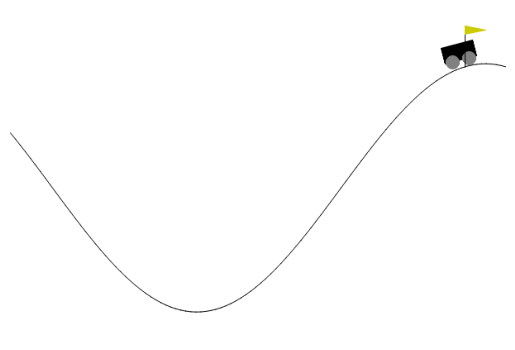

In [10]:
EPISODE_DIR = "episode_399"
def run_policy(
    render_mode="rgb_array",
    logdir="logs/mountaincar_continuous_action_llm_num_optim_400_std_1_expected_r_no_bias_range",
):
    world = MountaincarContinuousActionWorld(
        "MountainCarContinuous-v0", 
        render_mode=render_mode, 
        max_traj_length=MAX_TRAJ_LENGTH,
    )
    agent = MountaincarContinuousActionLLMNumOptimAgent(
        logdir=logdir,
        dim_action=1,
        dim_state=2,
        max_traj_count=MAX_TRAJ_COUNT,
        llm_si_template=llm_si_template,
        llm_model_name=LLM_MODEL_NAME,
        num_evaluation_episodes=NUM_EVALUATION_EPISODES,
    )

    weights = []
    with open(f"{logdir}/{EPISODE_DIR}/parameters.txt", "r") as f:
        weights.append([float(x) for x in f.readlines()[1:]])
    agent.policy.update_policy(weights)


    state = world.reset()

    state = np.expand_dims(state, axis=0)
    done = False
    step_idx = 0
    while not done:
        plt.close("all")
        plt.figure()
        plt.clf()
        img = world.env.render()
        if isinstance(img, np.ndarray):
            plt.imshow(img)
        else:
            img = np.array(img)
            plt.imshow(img)
        plt.axis('off')

        display.display(plt.gcf())
        display.clear_output(wait=True)

        action = agent.policy.get_action(state.T)
        action = np.reshape(action, (1, 1))
        next_state, reward, done = world.step(action)
        state = next_state
        step_idx += 1

run_policy()
plt.close("all")